# SVM. Метод опорных векторов + Кросс-валидация

В этом задании вы попрактикуетесь в применении метода опорных векторов, а также примените кросс-валидацию для подбора гиперпараметров и оценки качества моделей!

## Данные

В этой практической работе мы будем обучать модели машинного обучения, ставить эксперименты, подбирать гиперпараметры и сравнивать модели. Вам предлагается решить задачу бинарной классификации, а именно построить алгоритм, определяющий превысит ли средний заработок человека порог $50k. Каждый объект выборки — человек, для которого известны следующие признаки:
 - `age`
 - `workclass`
 - `fnlwgt`
 - `education`
 - `education-num`
 - `marital-status`
 - `occupation`
 - `relationship`
 - `race`
 - `sex`
 - `capital-gain`
 - `capital-loss`
 - `hours-per-week`

Более подробно про признаки можно почитать [здесь](http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names). Целевой признак записан в переменной *>50K,<=50K*.

## Бонус ноутбука

Все исследователи данных знают, что SVM из библиотеки `sklearn` работает крайне медленно, поэтому на практике не могут его применять для решения задач.

В этом ноутбуке мы используем средства библиотеки `sklearn intelex` для ускорения обучения SVM в 600 раз!

Ради интереса попробуйте после завершения выполнения заданий в ноутбуке удалить ячейки, связанные с установкой и импортом `sklearn intelex` и засечь время работы методов :)

In [ ]:
# убедимся, что версия python <= 3.10
!python --version

Python 3.10.12


In [ ]:
%%capture
!python -m pip install --upgrade pip
!pip install --upgrade scikit-learn-intelex

In [ ]:
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [ ]:
import pandas as pd
import numpy as np
import sys
import os
import site

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from matplotlib import pyplot as plt

sys.path.append(os.path.join(os.path.dirname(site.getsitepackages()[0]), "site-packages"))

## Метрика качества

В задании мы будем оценивать качество моделей с помощью метрики *AUC-ROC*.

Загрузим набор данных `data.adult.csv`.

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/evgpat/edu_stepik_practical_ml/main/datasets/data.adult.csv")

df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,">50K,<=50K"
0,34,Local-gov,284843,HS-grad,9,Never-married,Farming-fishing,Not-in-family,Black,Male,594,0,60,<=50K
1,40,Private,190290,Some-college,10,Divorced,Sales,Not-in-family,White,Male,0,0,40,<=50K
2,36,Local-gov,177858,Bachelors,13,Married-civ-spouse,Prof-specialty,Own-child,White,Male,0,0,40,<=50K
3,22,Private,184756,Some-college,10,Never-married,Sales,Own-child,White,Female,0,0,30,<=50K
4,47,Private,149700,Bachelors,13,Married-civ-spouse,Tech-support,Husband,White,Male,15024,0,40,>50K


Иногда в данных встречаются пропуски. Как задаются пропуски обычно либо прописывается в описании к данным, либо просто на месте пропуска после чтения данных оказывается значение `numpy.nan`.  
Более подробно о работе с пропусками в Pandas можно прочитать например [здесь](http://pandas.pydata.org/pandas-docs/stable/missing_data.html).

В данном датасете пропущенные значения обозначены как "?".

### Задание

Найдите все признаки, имеющие пропущенные значения.

Затем удалите из выборки все объекты с пропусками.

In [ ]:
# your code here
for c in df.columns:
    print(c, len(df[df[c] == '?']))

age 0
workclass 929
fnlwgt 0
education 0
education-num 0
marital-status 0
occupation 933
relationship 0
race 0
sex 0
capital-gain 0
capital-loss 0
hours-per-week 0
>50K,<=50K 0


In [ ]:
# проверим, сколько объектов в датафрейме
df.shape

(16280, 14)

In [ ]:
# your code here
indexes = df[(df['workclass'] == '?') | (df['occupation'] == '?')].index
df.drop(index=indexes, inplace=True)
# смотрим, сколько объектов стало
df.shape

(15347, 14)

Обычно после загрузки датасета всегда необходима его некоторая предобработка.  
В данном случае она будет заключаться в следующем:

 - Выделите целевую переменную y в отдельную переменную и преобразуйте к бинарному формату по правилу:  
 '>50K' - 1, '<=50K' - 0.
 - Выделите матрицу объект-признак `X`, содержащую только вещественные столбцы (числовые) и не содержащую целевой переменной
 - Обратите внимание, что не все признаки являются вещественными. В начале мы будем работать только с вещественными признаками. Выделите их отдельно.

In [ ]:
# your code here
y = df['>50K,<=50K'].map({'>50K': 1, '<=50K': 0})

In [ ]:
# your code here проверяем типы переменных
df.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
>50K,<=50K        object
dtype: object

In [ ]:
# your code here
num_features = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
x = df[num_features]
x.shape

(15347, 6)

### Задание

Cколько столбцов содержит матрица `X`?

Постройте гистограммы для признаков `age`, `fnlwgt`, `capital-gain`. Глядя на получившиеся графики в чем заключается особенность данных? На какие алгоритмы это может повлиять? Может ли масшитабирование повлиять на работу этих алгоритмов?

Ответьте на этот вопрос для себя устно.

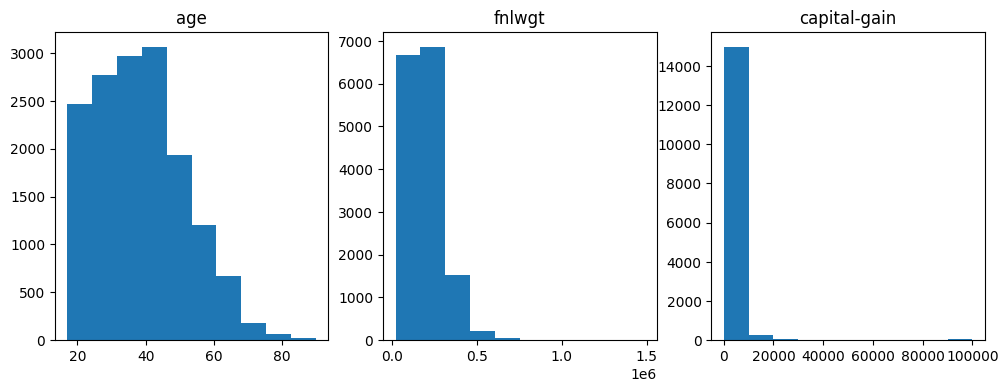

In [ ]:
# your code here
check_cols = ['age', 'fnlwgt', 'capital-gain']

fig, a = plt.subplots(1, 3, figsize=(12, 4))
plt.subplots_adjust(wspace=0.2)

for i in range(3):
    a[i].set_title(check_cols[i])
    a[i].hist(x[check_cols[i]])

**Из нижней оси видим, что масштаб очень сильно отличается. Линейные модели чувствительны к масштабу. Нужно нормировать**

Масштабируйте все вещественные признаки (масштабированную матрицу назовите, как и раньше, `X`).

In [ ]:
from sklearn.preprocessing import StandardScaler

# your code here
scaler = StandardScaler()
x = pd.DataFrame(scaler.fit_transform(x), columns=x.columns, index=x.index)

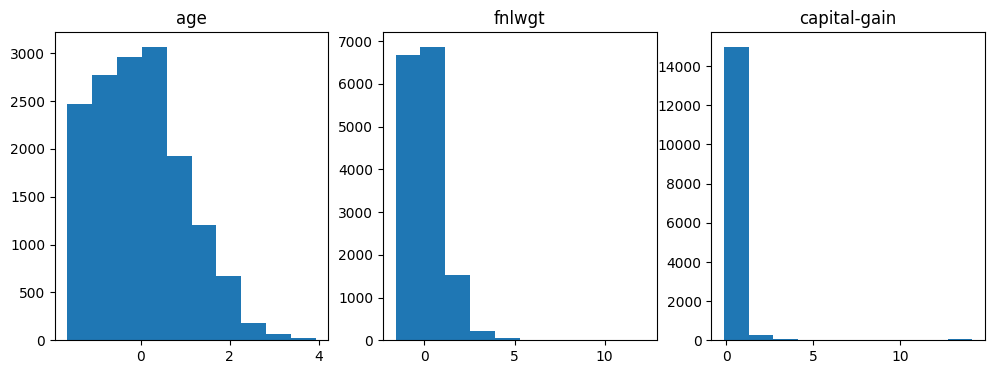

In [ ]:
# проверяем, что масштаб изменился (смотрим по нижней оси, где величины, т.к. по вертикальной оси - количество объектов)

check_cols = ['age', 'fnlwgt', 'capital-gain']

fig, a = plt.subplots(1, 3, figsize=(12, 4))
plt.subplots_adjust(wspace=0.2)

for i in range(3):
    a[i].set_title(check_cols[i])
    a[i].hist(x[check_cols[i]])
fig.show()

## Обучение классификаторов на вещественных признаках

В данном разделе необходимо будет работать только с вещественными признаками и целевой переменной.

В этом задании необходимо проверять качество алгоритмов по кросс-валидации. Напомним, что это за процесс.


### Кросс-валидация [обучающий текст]

Разбивать данные на train-test как мы делали раньше - неплохой подход. Однако при этом подходе мы привязываем и обучение модели, и оценку качества к конкретному разбиению, а для другого разбиения можем получить модель совершенно другого качества, что плохо.

Поэтому хочется оценить качество модели без привязки к конкретному разбиению на train-test. Для этого все обучающие данные разбиваются на несколько равных блоков (фолдов), и затем модель обучается несколько раз:
* первый раз - на всех блоках, кроме 1-го, а качество оценивается на 1-м блоке
* второй раз - на всех блоках, кроме 2-го, а качество оценивается на 2-м блоке и так далее
Для оценки качества модели полученные значения метрик на тестовых блоках усредняются - это называется *k-fold кросс-валидацией*.

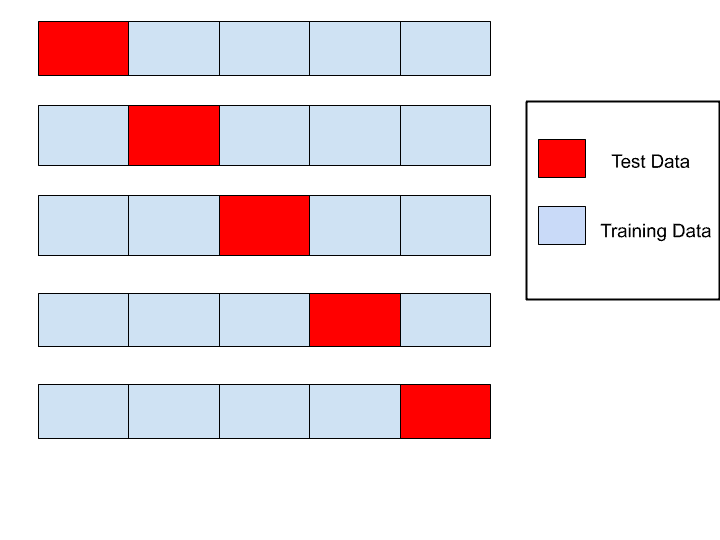

Сначала обучите по кросс-валидации c **тремя** фолдами и метрикой **roc_auc** алгоритмы:
*  LogisticRegression
*  SVC(kernel='linear')

Остальные параметры оставьте по умолчанию.

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score

# пример для логистической регрессии. verbose отвечает за детализацию выводимой информации. verbose=2 значит, что будет выводится score

model = LogisticRegression()
cross_val_score(model, x, y, cv=3, scoring='roc_auc', verbose=2).mean()

[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s


0.8250515880497281

In [ ]:
# посмотрите на среднее качество SVM с линейным ядром

# your code here

cross_val_score(SVC(kernel='linear'), x, y, cv=3, scoring='roc_auc', verbose=2).mean()

[CV] END .................................................... total time=   3.7s
[CV] END .................................................... total time=   6.9s
[CV] END .................................................... total time=   6.1s


0.8075427740991511

### Задание

Чему равно качество наилучшей из этих моделей?  
Ответ округлите до десятых.

Теперь посмотрим как влияет подбор гиперпараметров на качество предсказания моделей. Сейчас и далее будем рассматривать два алгоритма:
 - Logistic Regression
 - SVC (Support Vector Classifier)

У обоих алгоритмов будем оптимизировать гиперпараметр С, а у SVC - ещё гиперпараметр kernel.

*  Ищите C в диапазоне от 0.01 до 10.01 с шагом 0.25
*  Перебирайте ядра из списка ['rbf','poly','sigmoid','linear']

### Подбор гиперпараметров по сетке (GridSearchCV) [обучающий текст]

Раз уж мы начали использовать кросс-валидацию, то будем использовать ее по-максимуму. Для подбора гиперпараметров модели также можно применить этот подход вместо разбиения на train и test.

Идея подбора гиперпараметров по сетке:

* задаем список перебираемых значений гиперпараметров (можно подбирать одновременно несколько гиперпараметров)

* для каждого набора значений гиперпараметров вычисляем качество модели по кросс-валидации

* итоговый ответ - это набор значений гиперпараметров, для которого модель имеет наибольшее качество на кросс-валидации.

Метод, реализующий эту схему, называется GridSearchCV.

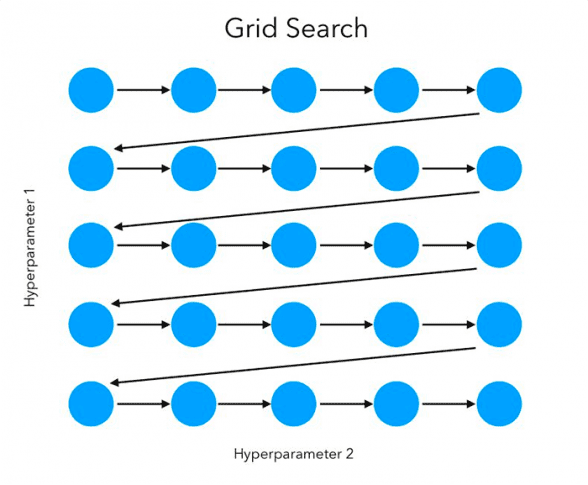

Для подбора гиперпараметров воспользуйтесь перебором по сетке, который реализован в классе GridSearchCV. В качестве схемы кросс-валидации используйте 3-fold cv.

Покажем пример использования GridSearchCV.

In [ ]:
# подберите C у логистической регрессии

from sklearn.model_selection import GridSearchCV

params = {'C' : np.arange(0.01, 10.01, 0.25)} # задаем словарь параметров и список перебираемых значений - в данном случае ищем C из списка [1,2,3]

gs = GridSearchCV(LogisticRegression(), params, cv=3, scoring='roc_auc')
# первый параметр - модель, второй - словарь параметров, третий - число фолдов, четвертый - метрика

gs.fit(x, y) # применяем метод к данным X, y (GridSearchCV сам разобъет данные на фолды)

print(gs.best_score_) # качество наилучшей модели (с оптимальными гиперпараметрами)
print(gs.best_params_) # оптимальные гиперпараметры

0.825109999279449
{'C': 0.26}


In [ ]:
# your code here
# так как SVM работает долго, то:
# сначала первым gridsearch подберите у метода только kernel

params2 = {'kernel' : ['rbf', 'poly', 'sigmoid', 'linear']}

gs2 = GridSearchCV(SVC(), params2, cv=3, scoring='roc_auc')

gs2.fit(x, y)

print(gs2.best_score_) # качество наилучшей модели (с оптимальными гиперпараметрами)
print(gs2.best_params_) # оптимальные гиперпараметры

0.8075427740991511
{'kernel': 'linear'}


In [ ]:
# вторым gridsearch для найденного ядра подберите C в диапазане от 0.01 до 2.01 с шагом 0.25
# your code here
params3 = {'C' : np.arange(0.01, 2.01, 0.25)}

gs3 = GridSearchCV(SVC(kernel='linear'), params3, cv=3, scoring='roc_auc')

gs3.fit(x, y)

print(gs3.best_score_) # качество наилучшей модели (с оптимальными гиперпараметрами)
print(gs3.best_params_) # оптимальные гиперпараметры

0.8117119347552277
{'C': 0.01}


### Задание

Какой из алгоритмов имеет наилучшее качество?

Сравните алгоритмы с точки зрения времени обучения. Обучение какого из алгоритмов работает дольше всего и, как вы думаете, почему?

## Добавление категориальных признаков в модели

Пока мы не использовали нечисловые признаки, которые есть в датасете. Давайте посмотрим, правильно ли мы сделали и увеличится ли качество моделей после добавлениях этих признаков.

*  Преобразуйте все категориальные признаки (исходной матрицы df) с помощью метода one-hot-encoding (например, это можно сделать с помощью функции [`pandas.get_dummies`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html). Чтобы избежать переобучения, в `get_dummies` поставьте гиперпараметр **`drop_first=True`**.

*  Заново масштабируйте данные

In [ ]:
X_old = df.drop('>50K,<=50K', axis=1)

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler

categorical = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex']

transformer=make_column_transformer((OneHotEncoder(drop='first'), categorical), remainder="passthrough")
transformed=transformer.fit_transform(X_old).toarray()
transformed_df=pd.DataFrame(transformed, columns=transformer.get_feature_names_out())

scaler = StandardScaler()

X_new = pd.DataFrame(scaler.fit_transform(transformed_df), columns=transformed_df.columns, index=transformed_df.index)
X_new.head()

,onehotencoder__workclass_Local-gov,onehotencoder__workclass_Private,onehotencoder__workclass_Self-emp-inc,onehotencoder__workclass_Self-emp-not-inc,onehotencoder__workclass_State-gov,onehotencoder__workclass_Without-pay,onehotencoder__education_11th,onehotencoder__education_12th,onehotencoder__education_1st-4th,onehotencoder__education_5th-6th,...,onehotencoder__race_Black,onehotencoder__race_Other,onehotencoder__race_White,onehotencoder__sex_Male,remainder__age,remainder__fnlwgt,remainder__education-num,remainder__capital-gain,remainder__capital-loss,remainder__hours-per-week
0,3.658322,-1.665953,-0.194785,-0.307272,-0.209455,-0.021362,-0.188017,-0.110762,-0.066712,-0.096639,...,3.101735,-0.08727,-2.443271,0.686401,-0.342919,0.900258,-0.450788,-0.065600,-0.21874,1.588223
1,-0.273349,0.600257,-0.194785,-0.307272,-0.209455,-0.021362,-0.188017,-0.110762,-0.066712,-0.096639,...,-0.322400,-0.08727,0.409287,0.686401,0.114760,0.010683,-0.059086,-0.150439,-0.21874,-0.074178
2,3.658322,-1.665953,-0.194785,-0.307272,-0.209455,-0.021362,-0.188017,-0.110762,-0.066712,-0.096639,...,-0.322400,-0.08727,0.409287,0.686401,-0.190359,-0.106280,1.116020,-0.150439,-0.21874,-0.074178
3,-0.273349,0.600257,-0.194785,-0.307272,-0.209455,-0.021362,-0.188017,-0.110762,-0.066712,-0.096639,...,-0.322400,-0.08727,0.409287,-1.456874,-1.258276,-0.041382,-0.059086,-0.150439,-0.21874,-0.905379
4,-0.273349,0.600257,-0.194785,-0.307272,-0.209455,-0.021362,-0.188017,-0.110762,-0.066712,-0.096639,...,-0.322400,-0.08727,0.409287,0.686401,0.648719,-0.371197,1.116020,1.995391,-0.21874,-0.074178


Так как после кодирования признаков получилось достаточно много, в этой работе мы не будем добавлять их и подбирать заново оптимальные гиперпараметры.

Обучите алгоритмы с наилучшими гиперпараметрами из предыдущего пункта. Дало ли добавление новых признаков прирост качества? Измеряйте качество как и раньше используя 3-Fold CV в функции `cross_val_score`.

In [ ]:
#your code here

model2 = LogisticRegression(C=0.26)
cross_val_score(model2, X_new, y, cv=3, scoring='roc_auc', verbose=2).mean()

[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s


0.9027489658933026

In [ ]:
#your code here

model3 = SVC(kernel='linear', C=0.01)
cross_val_score(model3, X_new, y, cv=3, scoring='roc_auc', verbose=2).mean()

[CV] END .................................................... total time=   2.4s
[CV] END .................................................... total time=   2.4s
[CV] END .................................................... total time=   2.8s


0.8981783460544577

Отличается ли теперь наилучший классификатор от наилучшего в предыдущем пункте?

### Задание

*  Разбейте данные на тренировочную и тестовую часть (либо данные только с числовыми признаками, либо данные после OneHot-кодировки - в зависимости от того, на каких данных модели лучше отработали).

**Вопрос:**  
стали ли модели лучше решать задачу при добавлении закодированных категориальных признаков?

*test_size = 0.25, random_state = 42*

* Cреди всех обученных в работе моделей возьмите наилучшую (по roc-auc).
Заново обучите эту модель на тренировочных данных, сделайте предсказание на тесте.

* Постройте roc-кривую и отметьте на ней значение roc-auc - по тестовым данным.

In [ ]:
from sklearn.model_selection import train_test_split

#your code here
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.25, random_state=42)

In [ ]:
model_total = LogisticRegression(C=0.26)
model_total.fit(X_train, y_train)

LogisticRegression(C=0.26)

In [ ]:
pred = model_total.predict_proba(X_test)[:,1]

roc_auc_total = roc_auc_score(y_test, pred)
print(roc_auc_total)

0.9046191595294051


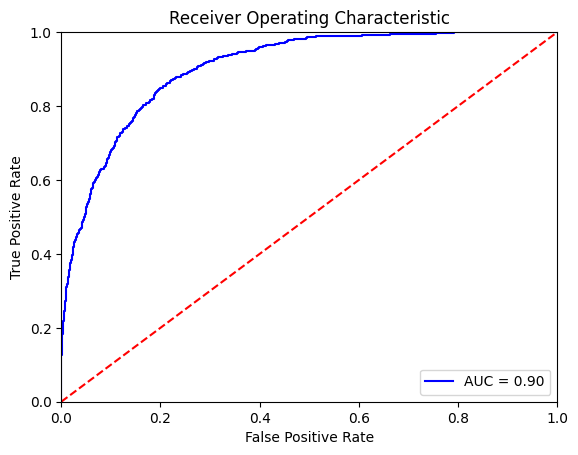

In [ ]:
from sklearn.metrics import roc_curve, auc

#your code here

fpr, tpr, threshold = roc_curve(y_test, pred)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

### Задание

Чему равен `roc-auc` наилучшей модели на тестовых данных?